# 1. 이상 탐지(Anomaly detection)

이상 탐지(anomaly detection)란 자료에서 다른 패턴을 보이는 자료를 찾는 것을 말합니다. 이런 데이터를 이상값(anomaly)라 하며 이상 탐지는 사기 탐지, 침입 탐지, 안전 관리를 포함한 다양한 분야에 널리 활용된다.

# 2. 이상의 종류

## 2.1. Point anomaly

데이터셋 내에 하나의 데이터가 나머지에 대해 이상하다고 판단되는 경우, 흔히 아웃라이어(Outlier)라고 부른다.

## 2.2. Collective anomaly

데이터셋 내에 여러 데이터 포인트가 이상하다고 판단되는 경우

## 2.3. Contextual anomaly

전체적인 데이터셋의 맥락을 고려했을때 이상하다고 판단되는 경우

# 3. Isolation forest

기계학습으로 이상을 탐지하는 다양한 알고리즘이 존재하고 문제 마다 적합한 알고리즘을 선택하는 것이 중요하다. 여기에서는 밀도기반으로 이상 탐지를 하는 [Isolation forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)의 예제를 배운다. 

Isolation forest는 기본적으로 데이터셋을 의사결정나무(Decision Tree) 형태로 표현해 정상값을 분리하기 위해서는 의사결정나무를 깊숙하게 타고 내려가야 하고, 반대로 이상값은 의사결정나무 상단부에서 분리할 수 있다는 것을 이용한다.

이 특성을 사용해 의사결정나무를 몇 회 타고 내려가야 분리되는가를 기준으로 정상과 이상을 분리한다.

Isolation forest의 장점

- 군집기반 이상탐지 알고리즘에 비해 계산량이 매우 적다
- 강건한(Robust)한 모델을 만들 수 있다


# 4. 예제 살펴보기

## 4.1. 가장 단순한 예제

먼저 사용할 라이브러리를 불러온다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.ensemble import IsolationForest

간단한 데이터를 생성한다.

In [2]:
rng = np.random.RandomState(42)
# Generating training data 
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])
# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])
# Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

생성한 데이터셋을 시각화해 살펴본다.

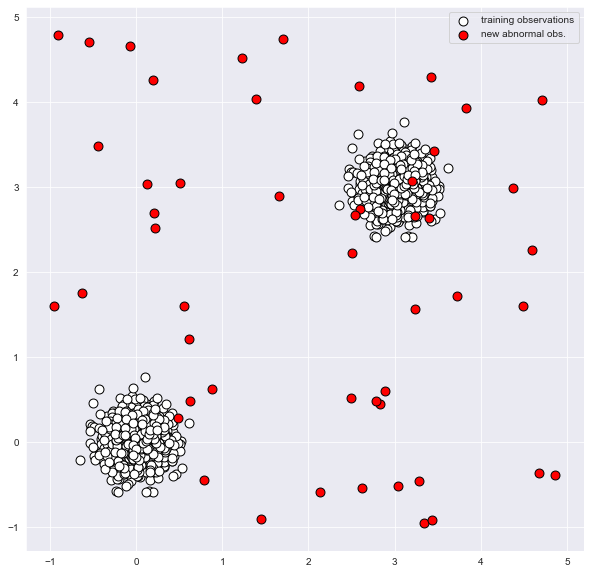

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*4, edgecolor='k', label='training observations')
# p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*4, edgecolor='k', label='new regular obs.')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.legend()

`scikit-learn`의 `IsolationForest` 함수를 이용해 학습 모델을 만든다.

In [4]:
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

학습된 모델을 가지고 `X_outliers` 데이터셋의 이상 탐지를 해보고 시각화를 통해 나타낸다.

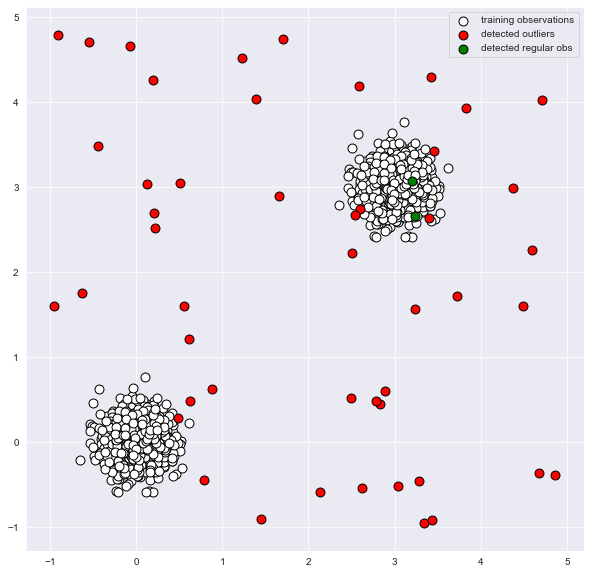

In [5]:
X_outliers = X_outliers.assign(y = y_pred_outliers)
p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.legend()

학습 모델의 정확도를 수치로 나타내본다.

In [6]:
print("테스트 데이터셋에서 정확도:", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("이상치 데이터셋에서 정확도:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

테스트 데이터셋에서 정확도: 0.905
이상치 데이터셋에서 정확도: 0.96


## 4.2. 더 복잡한 예제

좀 더 실용적인 예제로 직업에 따른 급여를 조사한 데이터셋을 가지고 이상 탐지를 해보자. 먼저 필요한 라이브러리와 데이터셋(`jobtitle_pay.csv`)을 불러온다.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
%matplotlib inline

salary = pd.read_csv('../data/jobtitle_pay.csv')
salary.tail()
df = salary.copy()

생성한 데이터프레임의 모양을 살펴보자.

In [8]:
df.head()

,JobTitle,TotalPay
0,Transit Operator,148711.28
1,Transit Operator,146680.39
2,Transit Operator,145024.94
3,Transit Operator,144704.29
4,Transit Operator,144557.78


데이터셋의 첫번째 열에는 직업의 이름(`JobTitle`)이 두번째 열에는 연봉(`TotalPay`)가 달러화 기준으로 나와 있다. 이제 데이터셋에 존재하는 직업의 종류와 각각 몇명의 데이터가 있는지 출력한다.

In [9]:
df['JobTitle'].value_counts()

Transit Operator                9424
Special Nurse                   4389
Registered Nurse                3736
Public Svc Aide-Public Works    2518
Police Officer 3                2421
Custodian                       2418
Firefighter                     2359
Recreation Leader               1971
Patient Care Assistant          1945
Name: JobTitle, dtype: int64

위 결과를 통해 총 9개의 직업이 많개는 9424명의 데이터에서 적게는 1945명의 데이터를 포함하고 있다는 것을 알 수 있다.

각 직업별로 박스플롯을 그려 평균 연봉이 어느정도 되는지 시각화해보자.

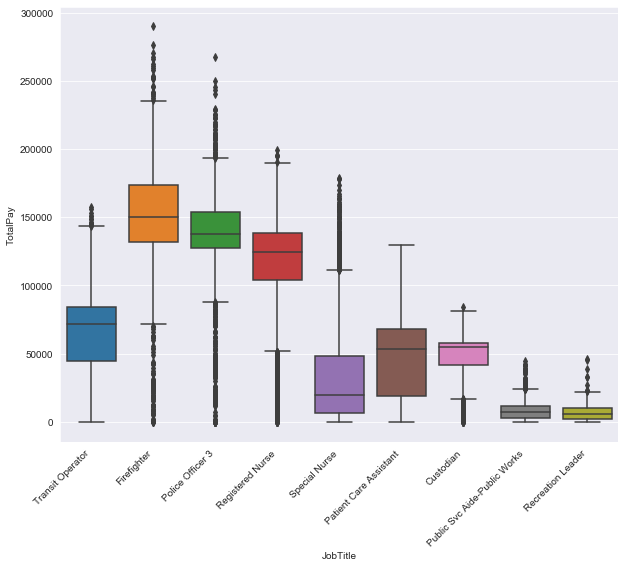

In [10]:
plt.figure(figsize=(10, 8))
plt.xticks(rotation=45, horizontalalignment='right')
sns.boxplot(x='JobTitle', y='TotalPay', data=df)

위 시각화를 통해 미국에서는 소방관(`Firefighter`)의 연봉이 높다는 것과 연봉의 분포가 일정하지 않다는 것을 알 수 있다.

기계학습을 위해 위의 데이터를 `LabelEncoder`를 통해 전처리 해줘야한다.

In [11]:
from sklearn.preprocessing import LabelEncoder
job_encode = LabelEncoder()
salary['JobTitle'] = job_encode.fit_transform(salary['JobTitle'])
salary.tail()

,JobTitle,TotalPay
31176,8,15.35
31177,6,6.00
31178,0,0.00
31179,0,0.00
31180,0,0.00


기계 학습모델을 만들어 학습을 수행한다.

In [12]:
model=IsolationForest(n_estimators=100, max_samples='auto', n_jobs=-1,
                      max_features=2, contamination=0.01)
model.fit(salary.to_numpy())

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=2, max_samples='auto', n_estimators=100, n_jobs=-1,
                random_state=None, verbose=0, warm_start=False)

데이터프레임에 평가 점수(`score`)와 이상(`anomaly`) 판단 여부에 대한 값을 추가한다. 

In [13]:
score = model.decision_function(salary.to_numpy())
anomaly = model.predict(salary.to_numpy())

df['scores']= score
df['anomaly']= anomaly
# salary.tail()
anomaly_data = df.loc[df['anomaly']==-1] # 이상값은 -1으로 나타낸다.
anomaly_data

,JobTitle,TotalPay,scores,anomaly
0,Transit Operator,148711.28,-0.009516,-1
1,Transit Operator,146680.39,-0.004878,-1
2388,Firefighter,290076.13,-0.071314,-1
2389,Firefighter,267951.41,-0.068877,-1
2390,Firefighter,259740.36,-0.066448,-1
...,...,...,...,...
31108,Custodian,192.04,-0.003087,-1
31155,Custodian,54.39,-0.002204,-1
31178,Custodian,0.00,-0.003087,-1
31179,Custodian,0.00,-0.003087,-1


총 31180개 데이터 중 312개의 데이터가 이상치로 판별된다. 이제 직업별로 이상치가 얼마나 되는지 살펴보자.

In [14]:
anomaly_data['JobTitle'].value_counts()

Firefighter         183
Police Officer 3     50
Registered Nurse     34
Custodian            24
Special Nurse        11
Transit Operator      9
Name: JobTitle, dtype: int64

총 9개의 직업에서 5개 직업에 이상치가 발견되며, 소방관에서 가장 많이 분포한다. 이제 시각화를 통해 이상치가 어떻게 분포하는지 살펴보자.

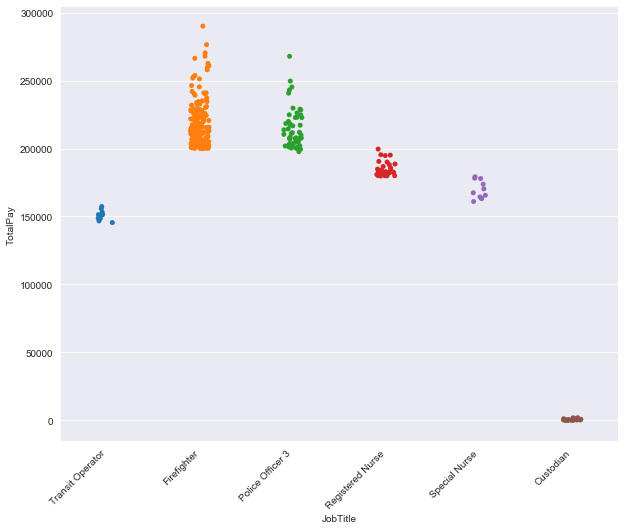

In [15]:
plt.figure(figsize=(10, 8))
plt.xticks(rotation=45, horizontalalignment='right')
sns.stripplot(x='JobTitle', y='TotalPay', data=anomaly_data, jitter=True)

시각화를 해보면 소방관과 후견인(`Custodian`)에서 연봉이 유난히 낮은 사람들을 볼 수 있다. 후견인의 경우는 생업을 위한 직업이라고는 볼 수 없기 때문에 제외하고 소방관에서 유난하게 낮은 값들을 찾아보자.

In [16]:
anomaly_data[
    (anomaly_data['JobTitle'] == 'Firefighter')&
    (anomaly_data['TotalPay'] < 10000.0)]

,JobTitle,TotalPay,scores,anomaly


위 결과를 보면 연봉이 0 달러인 사람들이 6명이며 10000 달러 이하인 사람이 2명이 있다. 연봉이 너무 낮기 때문에 상식적으로 위 데이터들은 이상치라고 볼 수 있다.

# 5. 마치며,

이 글에서 이상이 무엇인지, 그리고 Isolation forest 알고리즘을 사용해 감지하는 방법을 배웠다. 박스 플롯을 사용해 데이터셋을 살펴보고 마지막으로 Isolation forest 알고리즘을 구현했다. 

추가적으로 더 알아보고 싶다면 다음 링크를 확인하라.

- https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/outlier_detection_hampel_filter.ipynb
- https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2